# MỤC LỤC
* [1. Tiền xử lí và đặt vấn đề](#chapter1) 
    * [1.1 Cài đặt các thư viện cần thiết](#section_1_1)
    * [1.2 Nạp dữ liệu từ file data](#section_1_2)
    * [1.3 Tiền xử lí dữ liệu](#section_1_3)
    * [1.4 Đặt vấn đề](#section_1_4)
* [2. Xây dựng và so sánh các mô hình](#chapter2)
    * [2.1 Mô hình Random Forest](#section_2_1)
    * [2.2 Mô hình Logistic Regression](#section_2_2)
    * [2.3 Mô hình K-Nearest Neighbor](#section_2_3)
    * [2.4 Mô hình SVM](#section_2_4)
    * [2.5 Mô hình Neural Network](#section_2_5)
    * [2.6 Đánh giá và so sánh mô hình](#section_2_6)
    * [2.7 Phân tích vì sao Neural Network hiệu quả hơn các mô hình khác](#section_2_7)
* [3. Xây dựng mô hình có hiệu suất tốt nhất](#chapter3) 
    * [3.1 Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập validation ](#section_3_1)
    * [3.2 Xây dựng và huấn luyện mô hình trên tập huấn luyện và đánh giá trên tập validation](#section_3_2)
    * [3.3 Điều chỉnh hyperparameters dựa trên đánh giá trên tập validation](#section_3_3)
    * [3.4 Re-train mô hình trên (tập huấn luyện + tập validation) ](#section_3_4)
    * [3.5 Đánh giá mô hình cuối cùng trên tập kiểm tra](#section_3_5)


# 1. Tiền xử lí và đặt vấn đề <a class="anchor" id="chapter1"></a>

## 1.1. Cài đặt các thư viện cần thiết <a class="anchor" id="section_1_1"></a>

In [36]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer


from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import model_to_dot

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense
from keras.layers import Flatten
from keras.metrics import Precision, Recall, F1Score
from keras.callbacks import EarlyStopping
from keras.backend import clear_session
from keras.utils import to_categorical

## 1.2. Nạp dữ liệu từ file data <a class="anchor" id="section_1_2"></a>

In [37]:
df = pd.read_csv("../data/weather_data_combined.csv")
df.info()
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16900 entries, 0 to 16899
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Timestamp            16900 non-null  int64  
 1   Temperature          16900 non-null  float64
 2   Feels Like           16900 non-null  float64
 3   Temp Min             16900 non-null  float64
 4   Temp Max             16900 non-null  float64
 5   Pressure             16900 non-null  int64  
 6   Humidity             16900 non-null  int64  
 7   Weather Description  16900 non-null  object 
 8   Wind Speed           16900 non-null  float64
 9   Wind Degree          16900 non-null  int64  
 10  City                 16900 non-null  object 
dtypes: float64(5), int64(4), object(2)
memory usage: 1.4+ MB


,Timestamp,Temperature,Feels Like,Temp Min,Temp Max,Pressure,Humidity,Weather Description,Wind Speed,Wind Degree,City
0,1699542000,285.12,284.25,280.22,288.73,1011,72,overcast clouds,5.36,360,United States-New York City
1,1699545600,285.33,284.43,281.12,289.25,1011,70,overcast clouds,2.57,0,United States-New York City
2,1699549200,285.77,284.89,282.10,289.28,1010,69,overcast clouds,4.02,41,United States-New York City
3,1699552800,286.35,285.55,284.12,288.80,1009,70,broken clouds,4.63,270,United States-New York City
4,1699556400,286.98,286.19,285.34,289.13,1009,68,broken clouds,2.57,260,United States-New York City


### Giải thích chung về các chỉ số được sử dụng để đánh giá mô hình:
Bởi vì yêu cầu từ bài toán đặt ra thuộc dạng phân lớp nên các chỉ số sau là phù hợp nhất để đo lường hiệu suất mô hình:
- **Accuracy**: Biểu diễn tỷ lệ giữa số điểm *khẳng định đúng* và *phủ định đúng* trên *tổng số dự đoán* được đưa ra 
- **Recall**: Biểu diễn tỷ lệ giữa số điểm *khẳng định đúng* trên tổng số điểm mà tại đó là *đúng theo thực tế*
- **Precision**: Biểu diễn tỷ lệ giữa số điểm *khẳng định đúng* trên tổng số điểm mà tại đó là *đúng theo dự đoán của mô hình*
- **F1-Score**: Biểu diễn *trung bình điều hòa* giữa `Precision` và `Recall` 
- **Confusion Matrix**: Đối chiếu cụ thể những dự đoán được đưa ra bởi mô hình so với kết quả thực tế. Trong trường hợp của mô hình phân lớp với nhiều lớp dữ liệu khác nhau (*Multiclass*), ma trận gồm 2 trục tương ứng cho kết quả thực tế và dự đoán từ mô hình. Mỗi điểm trong ma trận biểu diễn số điểm đúng so với giả thuyết lần dự đoán của mô hình. 

## 1.3. Tiền xử lí dữ liệu <a class="anchor" id="section_1_3"></a>

In [38]:
#df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')
df['Timestamp'] = df['Timestamp'].astype('int64')/1e9
lb = LabelEncoder()
df['Weather Description'] = lb.fit_transform(df['Weather Description'])

In [39]:
# Split the data
X = df.drop(['Weather Description', 'City', 'Timestamp'], axis=1)
y = df['Weather Description']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 1.4. Đặt vấn đề <a class="anchor" id="section_1_4"></a>
### 1.4.1. Phân tích sơ bộ 
Trong những thuộc tính của bộ dữ liệu về thời tiết đã được thu thập, ta thấy rằng thuộc tính "weather description" (tạm dịch là "mô tả thời tiết") là thuộc tính mang yếu tố trực quan nhất và dễ hiểu nhất. Những cột thuộc tính khác đều thuộc dạng dữ liệu số như nhiệt độ, áp suật, sức gió,... ít nhiều cũng có đôi chút khó hiểu đối với những người không am hiểu rõ về khí tượng học. Trong khi đó, với cột mô tả thời tiết, ta gần như có thể hình dung ngay được thời tiết lúc đó trông ra sao, chẳng hạn như là mưa, tuyết rơi, có bão,... Cũng bởi điều này nên nếu như chúng ta có thể dự đoán được giá trị cột thuộc tính này sẽ mang lại không ít lợi ích trong việc chuẩn bị trước sự thay đổi thời tiết.

### 1.4.2. Mục đích
Mục đích chính của việc xây dựng mô hình như sau:
- **Dự báo thời tiết:** Bằng cách dự đoán “weather description”, chúng ta có thể dự đoán điều kiện thời tiết tương lai dựa trên dữ liệu lịch sử.
- **Nghiên cứu khí hậu:** Mô hình như vậy cũng có thể hữu ích trong nghiên cứu khí hậu. Hiểu biết về các mô hình thời tiết theo thời gian có thể giúp nghiên cứu biến đổi khí hậu và những tác động của nó.
- **Phân tích dữ liệu:** Những dự đoán từ mô hình này có thể giúp phân tích và hiểu rõ sự ảnh hưởng giữa các cột thuộc tính thời tiết khác nhau, ví dụ như nhiệt độ và độ ẩm có quan hệ như thế nào đối với cảnh quan thời tiết,...

### 1.4.3. Lợi ích
Kết quả dự doán từ mô hình sẽ đem lại một số lợi ích như:
- **Kế hoạch và quyết định:** Do nhiều ngành như nông nghiệp, xây dựng, du lịch, quản lý sự kiện chịu sự ảnh hưởng rất lớn từ thời tiết thiên nhiên nên việc dự đoán sẽ giúp lên kế hoạch và điều chỉnh hiệu quả trong ngành nghề
- **Biện pháp an toàn:** Dự đoán được thiên tai sẽ giúp chúng ta phòng bị tốt hơn để giảm thiểu tối đa ảnh hưởng tới con người và tài sản 
- **Quản lý nguồn lực:** Trong các ngành như nông nghiệp và năng lượng (đặc biệt là nguồn tái tạo như năng lượng mặt trời và gió), việc biết trước thời tiết có thể giúp quản lý và điều chỉnh nguồn lực một cách hiệu quả.

# 2. Xây dựng và so sánh các mô hình <a class="anchor" id="chapter2"></a>

## 2.1. Mô hình Random Forest <a class="anchor" id="section_2_1"></a>

In [40]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [41]:
# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)

recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{cm}')

Accuracy: 0.5905325443786982
Precision: 0.5555792616141045
Recall: 0.5905325443786982
F1 Score: 0.5290619453216618
Confusion Matrix: 
[[  87  218    0    6    2    0    0    0    4    0    0    0  104   13
     0    0    0]
 [  23 1323    0    7    1    1    0    0    0    0    1    0   61    8
     0    0    0]
 [   0    0    0    0    0    0    0    0    1    0    0    0    0    0
     0    0    0]
 [  13  215    0   25    0    0    0    0    0    1    2    0   25    9
     0    0    0]
 [   0    5    0    0    3    0    0    0    0    0    3    0    3    0
     0    0    0]
 [   0   36    0    0    1    3    0    0    0    0    0    0    1    1
     0    0    0]
 [   0    1    0    0    0    0    2    0    0    0    0    2    5    0
     0    0    0]
 [   0    1    0    0    0    0    0    0    0    0    0    0    5    0
     0    0    0]
 [   1    6    0    0    0    0    0    0    4    1    2    1   45    0
     0    0    0]
 [   0    0    0    0    0    0    0    0    1    6    0

**Nhận xét**
- Accuracy: Trong tất cả các dự đoán được đưa ra bởi mô hình, chỉ có khoảng 59% là chính xác.
- Precision: Trong tất cả các dự đoán mà mô hình cho là đúng, thì chỉ có khoảng 55% là đúng với thực tế.
- Recall: Trong tất cả các đối tượng được cho là đúng với thực tế, thì mô hình chỉ dự đoán được khoảng 59% trong số đó.
- F1 Score: Nhìn chung độ chính xác và độ bao phủ từ mô hình chỉ đạt 53%
- Confusion matrix: Từ ma trận ta thấy mô hình hoạt động hiệu quả trên một số lớp nhưng không tốt trên các lớp khác.

$\Rightarrow$ Các chỉ số cho thấy hiệu năng của mô hình chỉ nằm ở mức trung bình, vẫn cần cải thiện thêm.

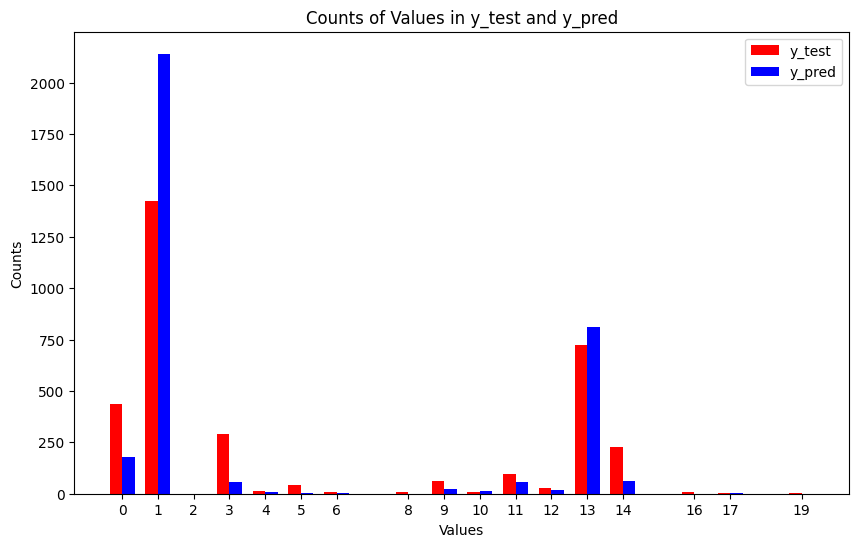

In [42]:
unique_values_y_test, counts_y_test = np.unique(y_test, return_counts=True)
unique_values_y_pred, counts_y_pred = np.unique(y_pred, return_counts=True)

# Create a bar plot
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(unique_values_y_test - width/2, counts_y_test, width, label='y_test', color='red')
bar2 = ax.bar(unique_values_y_pred + width/2, counts_y_pred, width, label='y_pred', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Counts of Values in y_test and y_pred')
ax.set_xticks(np.unique(np.concatenate([y_test, y_pred])))
ax.legend()

# Show the plot
plt.show()

## 2.2. Mô hình Logistic Regression <a class="anchor" id="section_2_2"></a>

In [15]:
model = LogisticRegression(solver='liblinear', multi_class='auto')

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred, zero_division=0))

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)

recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{cm}')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       434
           1       0.52      0.92      0.67      1425
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00       290
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        10
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        60
          10       0.00      0.00      0.00         8
          11       0.50      0.04      0.08        98
          12       0.00      0.00      0.00        27
          13       0.45      0.55      0.50       722
          14       0.00      0.00      0.00       229
          16       0.00      0.00      0.00         7
          17       0.00      0.00      0.00         5
          19       0.00      0.00      0.00         2

    accuracy              

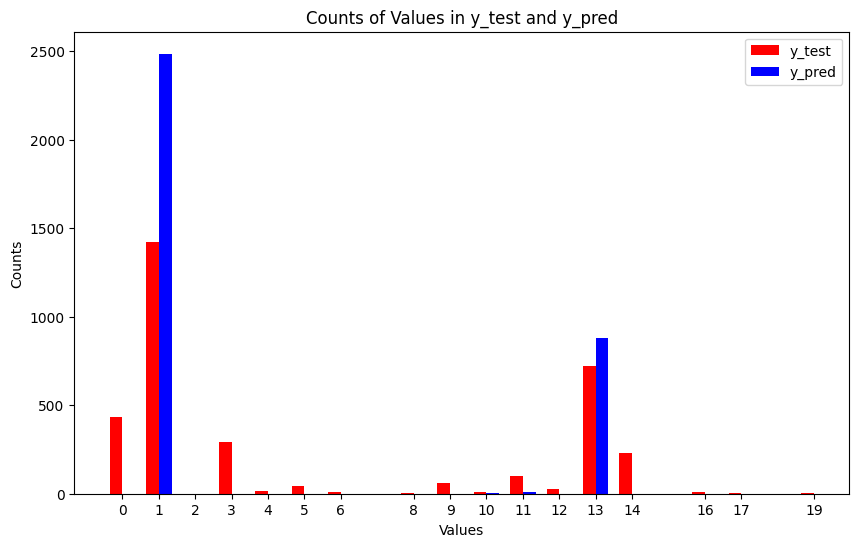

In [20]:
unique_values_y_test, counts_y_test = np.unique(y_test, return_counts=True)
unique_values_y_pred, counts_y_pred = np.unique(y_pred, return_counts=True)

# Create a bar plot
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(unique_values_y_test - width/2, counts_y_test, width, label='y_test', color='red')
bar2 = ax.bar(unique_values_y_pred + width/2, counts_y_pred, width, label='y_pred', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Counts of Values in y_test and y_pred')
ax.set_xticks(np.unique(np.concatenate([y_test, y_pred])))
ax.legend()

# Show the plot
plt.show()

## 2.3. Mô hình K-Nearest Neighbors <a class="anchor" id="section_2_3"></a>

In [23]:
# K-Nearest Neighbors (KNN)
knn_model = KNeighborsClassifier(n_neighbors=5)
knn_model.fit(X_train, y_train)
y_pred_knn = knn_model.predict(X_test)

# Calculate metrics for KNN
accuracy_knn = accuracy_score(y_test, y_pred_knn)
precision_knn = precision_score(y_test, y_pred_knn, average='weighted', zero_division=0)
recall_knn = recall_score(y_test, y_pred_knn, average='weighted')
f1_knn = f1_score(y_test, y_pred_knn, average='weighted')
cm_knn = confusion_matrix(y_test, y_pred_knn)

# Create DataFrame for KNN metrics
metrics_df_knn = pd.DataFrame({
    'Accuracy': [accuracy_knn],
    'Precision': [precision_knn],
    'Recall': [recall_knn],
    'F1 Score': [f1_knn]
})

# Print KNN metrics
print("Metrics (KNN):")
print(metrics_df_knn)

# Create DataFrame for KNN confusion matrix
cm_df_knn = pd.DataFrame(cm_knn, index=np.unique(y_test), columns=np.unique(y_test))

# Print KNN confusion matrix
print("\nConfusion Matrix (KNN):")
print(cm_df_knn)

Metrics (KNN):
   Accuracy  Precision    Recall  F1 Score
0  0.501479   0.441872  0.501479  0.455627

Confusion Matrix (KNN):
     0     1   2   3   4   5   6   8   9   10  11  12   13  14  16  17  19
0   109   225   0   8   3   0   0   0   1   1   2   1   70  14   0   0   0
1   101  1176   0  31   4   0   0   0   1   0   4   1   85  22   0   0   0
2     0     0   0   0   0   0   0   0   1   0   0   0    0   0   0   0   0
3    43   181   0  25   0   0   0   0   0   0   0   0   31  10   0   0   0
4     2     6   0   0   2   0   0   0   0   0   2   1    1   0   0   0   0
5     1    36   0   1   1   0   0   0   0   0   0   0    3   0   0   0   0
6     0     1   0   0   0   0   2   0   0   0   1   1    5   0   0   0   0
8     1     1   0   0   0   0   0   0   1   0   0   0    3   0   0   0   0
9     4     8   0   1   0   0   1   0   5   0   7   1   32   1   0   0   0
10    1     0   0   0   0   0   0   0   0   4   0   0    3   0   0   0   0
11    6    14   0   2   1   0   1   0   1   2  29

**Nhận xét**
- Accuracy: Trong tất cả các dự đoán được đưa ra bởi mô hình, chỉ có khoảng 50% là chính xác.
- Precision: Trong tất cả các dự đoán mà mô hình cho là đúng, thì chỉ có khoảng 33% là đúng với thực tế.
- Recall: Trong tất cả các đối tượng được cho là đúng với thực tế, thì mô hình chỉ dự đoán được khoảng 50% trong số đó.
- F1 Score: Nhìn chung độ chính xác và độ bao phủ từ mô hình chỉ đạt 37%
- Confusion matrix: Từ ma trận ta thấy mô hình hoạt động hiệu quả trên lớp 1 và lớp 13 nhưng cực kém trên các lớp khác.

$\Rightarrow$ Chỉ số Accuracy ở mức trung bình còn chỉ số F1 chỉ nằm ở mức yếu cho thấy hiệu năng tổng quan của mô hình yếu

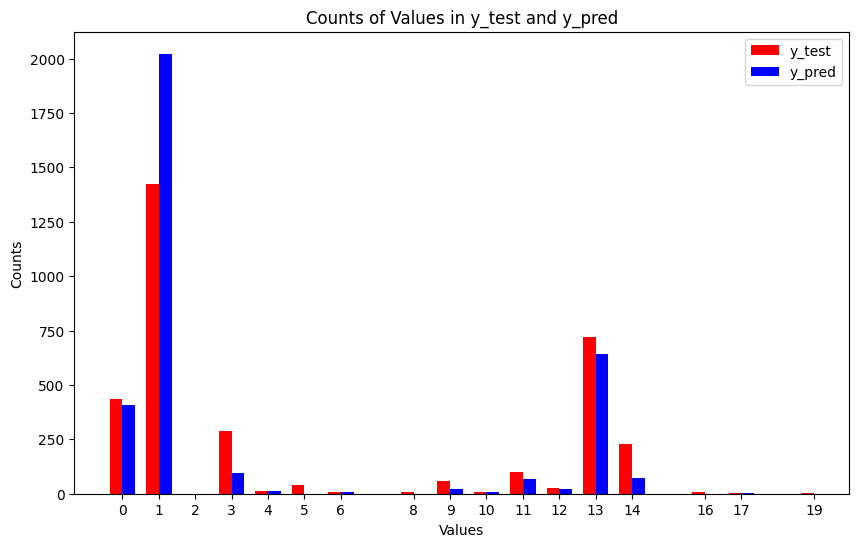

In [24]:
unique_values_y_test, counts_y_test = np.unique(y_test, return_counts=True)
unique_values_y_pred, counts_y_pred = np.unique(y_pred_knn, return_counts=True)

# Create a bar plot
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(unique_values_y_test - width/2, counts_y_test, width, label='y_test', color='red')
bar2 = ax.bar(unique_values_y_pred + width/2, counts_y_pred, width, label='y_pred', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Counts of Values in y_test and y_pred')
ax.set_xticks(np.unique(np.concatenate([y_test, y_pred_knn])))
ax.legend()

# Show the plot
plt.show()

## 2.4. Mô hình SVM <a class="anchor" id="section_2_4"></a>

In [25]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)

# Create an SVM model
model = SVC(kernel='linear', C=1.0)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Print a classification report
print(classification_report(y_test, y_pred, zero_division=0))

# Calculate metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print metrics
print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall: {recall}')
print(f'F1 Score: {f1}')

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print(f'Confusion Matrix: \n{cm}')

              precision    recall  f1-score   support

           0       0.00      0.00      0.00       434
           1       0.54      0.90      0.67      1425
           2       0.00      0.00      0.00         1
           3       0.00      0.00      0.00       290
           4       0.00      0.00      0.00        14
           5       0.00      0.00      0.00        42
           6       0.00      0.00      0.00        10
           8       0.00      0.00      0.00         6
           9       0.00      0.00      0.00        60
          10       0.42      0.62      0.50         8
          11       0.37      0.07      0.12        98
          12       0.00      0.00      0.00        27
          13       0.44      0.58      0.50       722
          14       0.00      0.00      0.00       229
          16       0.00      0.00      0.00         7
          17       0.40      0.40      0.40         5
          19       0.00      0.00      0.00         2

    accuracy              

**Nhận xét**
- Accuracy: Trong tất cả các dự đoán được đưa ra bởi mô hình, chỉ có khoảng 51% là chính xác.
- Precision: Trong tất cả các dự đoán mà mô hình cho là đúng, thì chỉ có khoảng 33% là đúng với thực tế.
- Recall: Trong tất cả các đối tượng được cho là đúng với thực tế, thì mô hình chỉ dự đoán được khoảng 51% trong số đó.
- F1 Score: Nhìn chung độ chính xác và độ bao phủ từ mô hình chỉ đạt 40%
- Confusion matrix: Từ ma trận ta thấy mô hình có xu hướng dự đoán nhiều vào lớp 1 và lớp 13, trong khi bỏ sót hoặc dự đoán sai nhiều các lớp khác

$\Rightarrow$ Từ các chỉ số được cung cấp, ta thấy hiệu năng của mô hình chỉ đạt mức kém

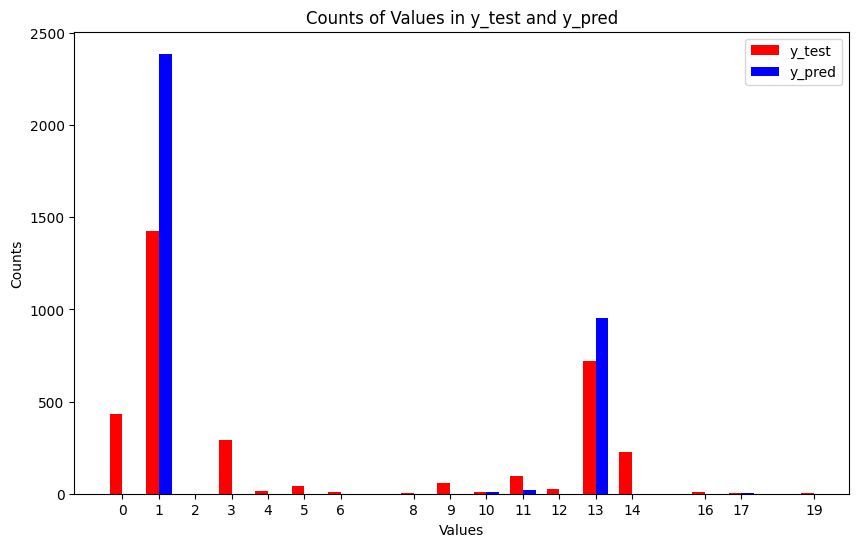

In [26]:
unique_values_y_test, counts_y_test = np.unique(y_test, return_counts=True)
unique_values_y_pred, counts_y_pred = np.unique(y_pred, return_counts=True)

# Create a bar plot
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(unique_values_y_test - width/2, counts_y_test, width, label='y_test', color='red')
bar2 = ax.bar(unique_values_y_pred + width/2, counts_y_pred, width, label='y_pred', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Counts of Values in y_test and y_pred')
ax.set_xticks(np.unique(np.concatenate([y_test, y_pred])))
ax.legend()

# Show the plot
plt.show()

## 2.5. Mô hình Neural Network <a class="anchor" id="section_2_5"></a>

In [27]:
# Assuming you have a 'text' column and a 'weather' column in your DataFrame
X_text = df['Weather Description'].astype(str).values  # Convert to string
X_numeric = df[['Temperature', 'Feels Like', 'Temp Min', 'Temp Max', 'Pressure', 'Humidity', 'Wind Speed', 'Wind Degree']]

# Convert labels to numerical values
le = LabelEncoder()
y = le.fit_transform(df['Weather Description'])

# Tokenize the text data
max_vocab_size = 16000  # Adjust as needed
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_text)
X_text = tokenizer.texts_to_sequences(X_text)

# Pad sequences to a fixed length
max_len = max(len(seq) for seq in X_text)
X_text = pad_sequences(X_text, maxlen=max_len)

# Define the preprocessing pipeline for numeric features
numeric_features = ['Temperature', 'Feels Like', 'Temp Min', 'Temp Max', 'Pressure', 'Humidity', 'Wind Speed', 'Wind Degree']
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# Combine text and numeric features
preprocessor = ColumnTransformer(
    transformers=[
        ('text', Tokenizer(), 'Weather Description'),
        ('num', numeric_transformer, numeric_features)
    ]
)

# Chia dữ liệu thành tập huấn luyện và tập kiểm tra
X_train, X_test, y_train, y_test = train_test_split(X_text, y, test_size=0.2, random_state=42)

# Xây dựng mô hình
embedding_dim = 50  # Đặt kích thước của không gian embedding
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(len(le.classes_), activation='sigmoid'))

# Biên soạn và huấn luyện mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Đánh giá mô hình
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Epoch 1/10
423/423 [==============================] - 1s 3ms/step - loss: 0.9064 - accuracy: 0.8992 - val_loss: 0.1060 - val_accuracy: 0.9719
Epoch 2/10
423/423 [==============================] - 2s 4ms/step - loss: 0.0568 - accuracy: 0.9850 - val_loss: 0.0245 - val_accuracy: 0.9953
Epoch 3/10
423/423 [==============================] - 1s 3ms/step - loss: 0.0160 - accuracy: 0.9975 - val_loss: 0.0098 - val_accuracy: 0.9991
Epoch 4/10
423/423 [==============================] - 1s 3ms/step - loss: 0.0073 - accuracy: 0.9990 - val_loss: 0.0049 - val_accuracy: 0.9991
Epoch 5/10
423/423 [==============================] - 1s 3ms/step - loss: 0.0046 - accuracy: 0.9990 - val_loss: 0.0034 - val_accuracy: 0.9991
Epoch 6/10
423/423 [==============================] - 1s 3ms/step - loss: 0.0036 - accuracy: 0.9990 - val_loss: 0.0027 - val_accuracy: 0.9991
Epoch 7/10
423/423 [==============================] - 1s 3ms/step - loss: 0.0030 - accuracy: 0.9990 - val_loss: 0.0022 - val_accuracy: 0.9991
Epoch 

In [28]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

# print("Classification Report:")
# print(classification_report(y_test, y_pred, zero_division=0))
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted')
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

106/106 [==============================] - 0s 297us/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


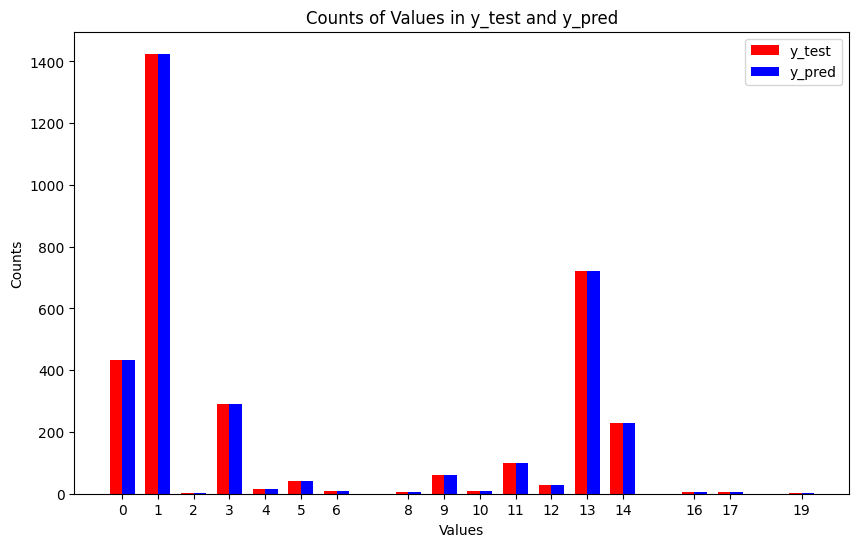

In [29]:
unique_values_y_test, counts_y_test = np.unique(y_test, return_counts=True)
unique_values_y_pred, counts_y_pred = np.unique(y_pred, return_counts=True)

# Create a bar plot
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(unique_values_y_test - width/2, counts_y_test, width, label='y_test', color='red')
bar2 = ax.bar(unique_values_y_pred + width/2, counts_y_pred, width, label='y_pred', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Counts of Values in y_test and y_pred')
ax.set_xticks(np.unique(np.concatenate([y_test, y_pred])))
ax.legend()

# Show the plot
plt.show()

**Nhận xét**
- Accuracy: Trong tất cả các dự đoán được đưa ra bởi mô hình, độ chính xác rơi vào khoảng 99%.
- Precision: Trong tất cả các dự đoán mà mô hình cho là đúng, 99% số dự đoán đúng so với thực tế.
- Recall: Trong tất cả các đối tượng được cho là đúng với thực tế, thì mô hình dự đoán đúng 99%.
- F1 Score: Nhìn chung độ chính xác và độ bao phủ từ mô hình đạt mức 99%

$\Rightarrow$ Từ các chỉ số được cung cấp, ta thấy hiệu năng của mô hình đạt hiệu quả rất cao.

## 2.6. So sánh và lựa chọn mô hình <a class="anchor" id="section_2_6"></a>
**Nhận xét chung**: Trong các mô hình đã xây dựng ở trên, có 2 mô hình đạt hiệu quả kém (SVM, Logistic Regression), 2 mô hình đạt hiệu quả trung bình (KNN, Random Forest) và 1 mô hình đạt hiệu quả cao (Neural Network).

Điều này có thể được giải thích dựa trên một số yếu tố như sau: 
- Chênh lệch vốn có trong dữ liệu đầu vào: Trong lớp dự đoán ta nhận thấy sự phân bố không đồng đều trong các giá trị từ mỗi lớp con khác nhau (có lớp chiếm hơn 1000 đối tượng nhưng lại có nhiều lớp chỉ có tầm 10-20 đối tượng) $\Rightarrow$ Việc chênh lệch mẫu ít nhiều cũng gây ảnh hưởng tới cách mô hình dự đoán
- Độ phức tạp trong các mô hình được cài đặt: Nếu so sánh 4 mô hình đầu vơi mô hình Neural Network, ta nhân thấy sự chênh lệch trong cách cài đặt thuật toán. Cụ thể, với mô hình Neural Network, ta có tổ chức phân tầng và chạy mô hình nhiều giai đoạn. Điều này vô hình chung tạo nên điều kiện rất tốt để mô hình có thể liên tục cải thiện độ chính xác nói riêng và các chỉ số đo lường hiệu suất nói chung. Tuy vậy, việc đạt được hiệu quả tuyệt đối cũng làm dấy lên quan ngại rằng mô hình có thể đạt phải tình trạng Overfitting

**Lựa chọn mô hình** Do vậy, nhóm em sẽ lựa chọn mô hình Neural Network để phân tích và điều chỉnh siêu tham số để quan sát ảnh hưởng tới hiệu suất đạt được

## 2.7. Phân tích vì sao network hiệu quả hơn các mô hình khác
### Ưu điểm của mô hình Neural Network
- **Đặc tính phi tuyến của mô hình:** Neural Network có khả năng học các biểu diễn phi tuyến tính và phi tuyến tính phức tạp từ dữ liệu, điều này giúp nó có khả năng mô hình hóa mối quan hệ phức tạp giữa các thuộc tính và Weather Description.
- **Kích thước mô hình:** Mô hình Neural Network của nhóm em được xây dựng với 5 lớp:
    - **Một lớp Embedding:** giúp mô hình học biểu diễn dữ liệu văn bản.
    - **Một lớp Flatten:** giúp chuyển đổi dữ liệu từ một định dạng nhiều chiều thành một vectơ một chiều. 
    - **Một lớp fully connected với 128 neuron với hàm relu:** giúp giữ nguyên giá trị dương và chuyển giá trị âm thành 0, từ đó giúp mô hình có khả năng học được các biểu diễn phi tuyến tính và các mối quan hệ phức tạp trong dữ liệu.
    - **Một lớp Dense với softmax activation:** Hàm softmax chuyển đầu vào thành một phân phối xác suất, nó thường được sử dụng trong lớp output của mô hình phân loại nhiều lớp (phù hợp với bài toán của nhóm chúng em).    
    
    $\rightarrow$ Mặc dù kích thước của mô hình không lớn, nhưng nó có độ linh hoạt cao.
### Nhược điểm của các mô hình khác
- **Khả năng phân biệt tuyến tính (SVM và Logistic Regression):** SVM và Logistic Regression là những mô hình được thiết kế để xử lý dữ liệu có tính chất tuyến tính, nghĩa là dữ liệu có thể được phân loại hoặc tìm ra ranh giới quyết định bằng một đường thẳng hay mặt phẳng. Nếu dữ liệu của bạn có mối quan hệ phức tạp và không tuyến tính, chúng có thể không hiệu quả.
- **Tính chất phi tuyến tính (k-Nearest Neighbors và Random Forest):** Khi dữ liệu không phải là tuyến tính, các mô hình như k-Nearest Neighbors (kNN) và Random Forest có thể gặp khó khăn trong việc học mối quan hệ phức tạp. Các mô hình này có xu hướng hiệu quả hơn trong các tình huống tuyến tính hoặc khi có sự tương quan đơn giản giữa các đặc trưng và nhãn.
- **Khả năng chịu nhiễu (k-Nearest Neighbors và Logistic Regression):** K-Nearest Neighbors và Logistic Regression có thể nhạy cảm với nhiễu trong dữ liệu. Nếu có nhiễu hoặc dữ liệu không đồng đều, chúng có thể không hiệu quả.

In [13]:
# Xác định cột chứa văn bản
text_column = 'Weather Description'

# Lấy ra toàn bộ văn bản từ cột
all_text = df[text_column].astype(str).values

# Khởi tạo Tokenizer và fit trên dữ liệu
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_text)

# Xác định max_vocab_size dựa trên số từ vựng trong tokenizer
max_vocab_size = len(tokenizer.word_index)
print("Max Vocab Size:", max_vocab_size)

Max Vocab Size: 20


In [14]:
# Đọc dữ liệu từ file hoặc nguồn dữ liệu khác
# df = pd.read_csv('your_data.csv')

# Xác định cột chứa văn bản
text_column = 'Weather Description'

# Lấy giá trị và số lần xuất hiện của chúng
word_counts = df[text_column].value_counts()

# In ra một số giá trị đầu tiên
print(word_counts.head())

Weather Description
1     7344
13    3710
0     2018
3     1380
14    1028
Name: count, dtype: int64


# 3. Chạy mô hình đạt hiệu quả cao nhất <a class="anchor" id="chapter3"></a>

## 3.1. Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập validation <a class="anchor" id="section_3_1"></a>

In [44]:
# Assuming you have a 'text' column and a 'weather' column in your DataFrame
X_text = df['Weather Description'].astype(str).values  # Convert to string
# Convert labels to numerical values
le = LabelEncoder()
y = le.fit_transform(df['Weather Description'])

# Tokenize the text data
max_vocab_size = 21  # Adjust as needed
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(X_text)
X_text = tokenizer.texts_to_sequences(X_text)

# Pad sequences to a fixed length
max_len = max(len(seq) for seq in X_text)
X_text = pad_sequences(X_text, maxlen=max_len)

# Chia dữ liệu thành tập huấn luyện, tập kiểm tra và tập validation
X_train, X_temp, y_train, y_temp = train_test_split(X_text, y, test_size=0.2, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


## 3.2. Xây dựng và huấn luyện mô hình trên tập huấn luyện và đánh giá trên tập validation <a class="anchor" id="section_3_2"></a>

Epoch 1/10
423/423 [==============================] - 0s 577us/step - loss: 0.9509 - accuracy: 0.8359 - val_loss: 0.0759 - val_accuracy: 0.9870
Epoch 2/10
423/423 [==============================] - 0s 456us/step - loss: 0.0493 - accuracy: 0.9861 - val_loss: 0.0265 - val_accuracy: 0.9923
Epoch 3/10
423/423 [==============================] - 0s 453us/step - loss: 0.0200 - accuracy: 0.9958 - val_loss: 0.0114 - val_accuracy: 0.9982
Epoch 4/10
423/423 [==============================] - 0s 451us/step - loss: 0.0084 - accuracy: 0.9990 - val_loss: 0.0067 - val_accuracy: 0.9982
Epoch 5/10
423/423 [==============================] - 0s 463us/step - loss: 0.0047 - accuracy: 0.9993 - val_loss: 0.0048 - val_accuracy: 0.9994
Epoch 6/10
423/423 [==============================] - 0s 459us/step - loss: 0.0034 - accuracy: 0.9994 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 7/10
423/423 [==============================] - 0s 457us/step - loss: 0.0026 - accuracy: 0.9994 - val_loss: 0.0025 - val_accuracy:

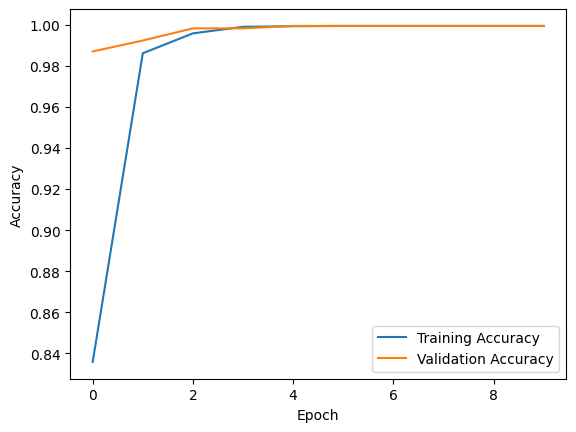

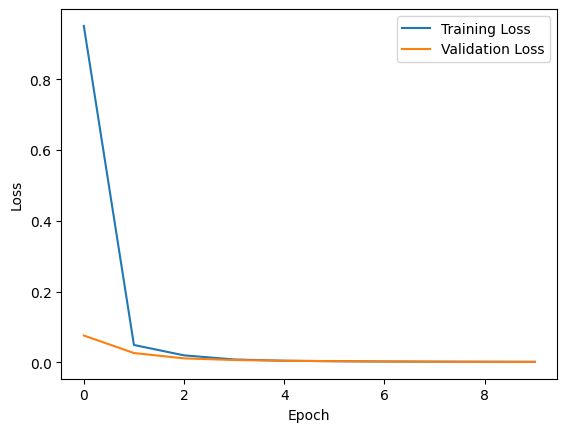

53/53 [==============================] - 0s 321us/step


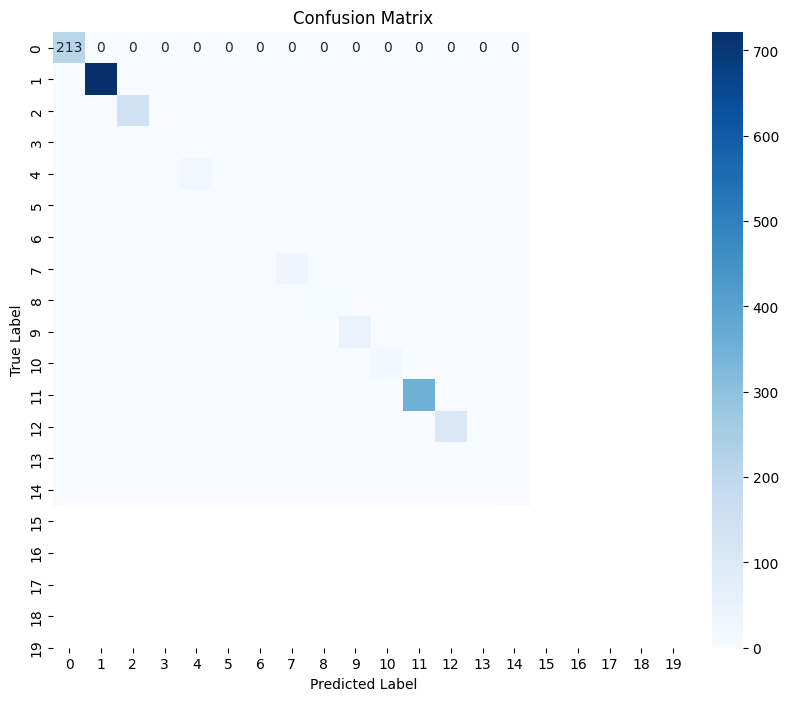

In [45]:
# Xây dựng mô hình
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(10, activation='relu'))
model.add(Dense(len(le.classes_), activation='softmax'))

# Biên soạn mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Huấn luyện mô hình trên tập huấn luyện và đánh giá trên tập validation
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Biểu đồ accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Biểu đồ loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

from sklearn.metrics import confusion_matrix
import seaborn as sns

# Dự đoán trên tập kiểm thử
y_probabilities = model.predict(X_test)
y_pred = np.argmax(y_probabilities, axis=1)

# Tính ma trận confusion
cm = confusion_matrix(y_test, y_pred)

# Vẽ ma trận confusion bằng seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


## 3.3. Điều chỉnh hyperparameters dựa trên đánh giá trên tập validation <a class="anchor" id="section_3_3"></a>

Dựa vào kết quả huấn luyện và đánh giá trên tập validation, mô hình đã cho thấy hiệu suất rất tốt với độ chính xác lên đến 99.99% trên tập validation. Dưới đây là một số điều nhóm đề xuất để điều chỉnh hyperparameters:

**Số lượng epochs:**
Dựa vào kết quả, mô hình có vẻ đã hội tụ khá nhanh với số lượng epochs tương đối ít.
Nhóm nhận thấy có thể thử giảm số lượng epochs hoặc sử dụng early stopping để ngừng huấn luyện khi không có cải thiện đáng kể.

**Batch size:**
Batch size hiện đang là 32. Nhóm dự định thử nghiệm các giá trị khác nhau để xem liệu có sự thay đổi nào không.

**Kích thước embedding (embedding_dim):**
Nhóm em đã sử dụng embedding_dim = 50, có thể thử các giá trị khác nhau, ví dụ như 32, 64, 128, để xem liệu có sự cải thiện nào không.

**Tăng cường dữ liệu (Data Augmentation):**
có thể thử tăng cường dữ liệu để cải thiện khả năng tổng quát hóa của mô hình.

**Dropout:**
Thêm dropout layer để giảm overfitting.

**Learning rate:**
Thử điều chỉnh learning rate.

Epoch 1/10
423/423 [==============================] - 0s 669us/step - loss: 0.5066 - accuracy: 0.9525 - val_loss: 0.0235 - val_accuracy: 0.9953
Epoch 2/10
423/423 [==============================] - 0s 570us/step - loss: 0.0204 - accuracy: 0.9970 - val_loss: 0.0076 - val_accuracy: 0.9982
Epoch 3/10
423/423 [==============================] - 0s 571us/step - loss: 0.0072 - accuracy: 0.9990 - val_loss: 0.0048 - val_accuracy: 0.9994
Epoch 4/10
423/423 [==============================] - 0s 563us/step - loss: 0.0043 - accuracy: 0.9990 - val_loss: 0.0035 - val_accuracy: 0.9994
Epoch 5/10
423/423 [==============================] - 0s 571us/step - loss: 0.0031 - accuracy: 0.9994 - val_loss: 0.0021 - val_accuracy: 0.9994
Epoch 6/10
423/423 [==============================] - 0s 562us/step - loss: 0.0023 - accuracy: 0.9995 - val_loss: 0.0014 - val_accuracy: 1.0000
Epoch 7/10
423/423 [==============================] - 0s 567us/step - loss: 0.0019 - accuracy: 0.9995 - val_loss: 8.5880e-04 - val_accur

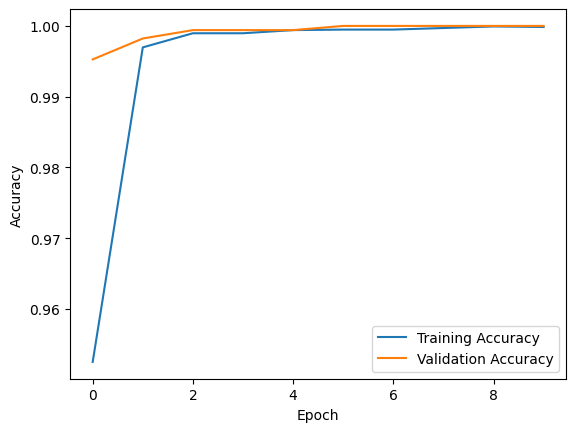

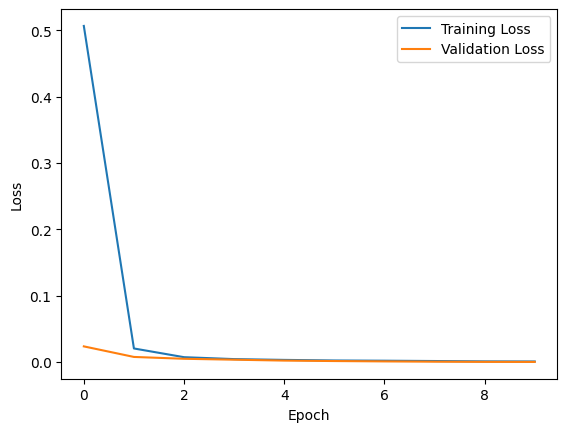

In [46]:
# Xây dựng mô hình
embedding_dim = 50
model = Sequential()
model.add(Embedding(input_dim=max_vocab_size, output_dim=embedding_dim, input_length=max_len))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))  # Thêm Dropout Layer để giảm overfitting
model.add(Dense(len(le.classes_), activation='softmax'))

# Biên soạn mô hình
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Sử dụng Early Stopping để ngừng huấn luyện khi không có cải thiện trên tập validation
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

# Huấn luyện mô hình trên tập huấn luyện và đánh giá trên tập validation
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Biểu đồ accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Biểu đồ loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

**Nhận xét hiệu quả từ việc điều chỉnh siêu tham số**: Có sự tiệm cận sát về độ chính xác lẫn độ mất mát giữa tập train và tập validation sau khi điều chỉnh, cho thấy rằng việc này ít nhiều cũng tạo ra sự tăng cường trong độ hiệu quả của mô hình.

## 3.4. Re-train mô hình trên (tập huấn luyện + tập validation) <a class="anchor" id="section_3_4"></a>

Epoch 1/5
423/423 [==============================] - 0s 616us/step - loss: 5.4088e-04 - accuracy: 0.9999 - val_loss: 2.7149e-05 - val_accuracy: 1.0000
Epoch 2/5
423/423 [==============================] - 0s 558us/step - loss: 3.3765e-04 - accuracy: 0.9999 - val_loss: 2.0769e-05 - val_accuracy: 1.0000
Epoch 3/5
423/423 [==============================] - 0s 572us/step - loss: 2.2228e-04 - accuracy: 1.0000 - val_loss: 1.5171e-05 - val_accuracy: 1.0000
Epoch 4/5
423/423 [==============================] - 0s 563us/step - loss: 2.1114e-04 - accuracy: 1.0000 - val_loss: 1.1988e-05 - val_accuracy: 1.0000
Epoch 5/5
423/423 [==============================] - 0s 601us/step - loss: 1.2840e-04 - accuracy: 1.0000 - val_loss: 6.1141e-06 - val_accuracy: 1.0000


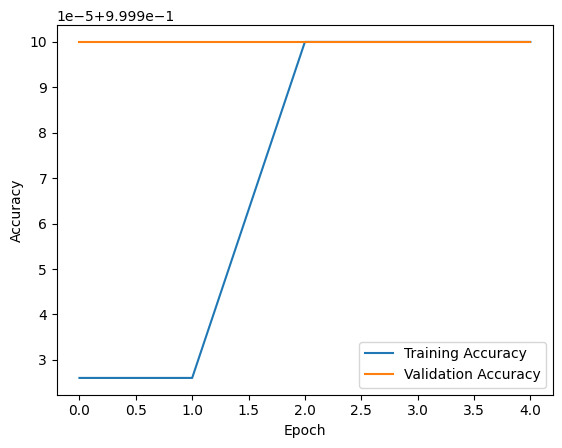

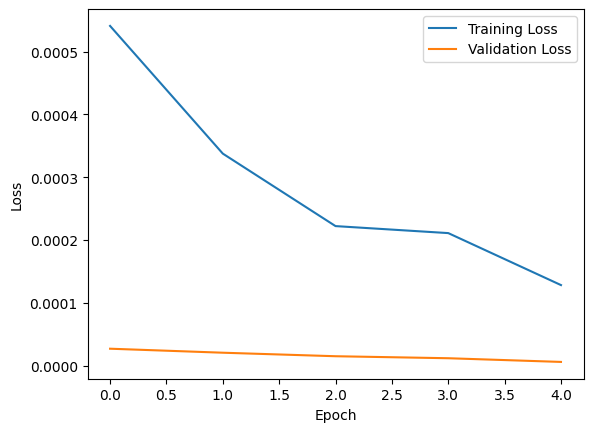

In [47]:
best_epochs = 5  
best_batch_size = 32  

X_train_final = np.concatenate((X_train, X_val))
y_train_final = np.concatenate((y_train, y_val))

# model.fit(X_train_final, y_train_final, epochs=best_epochs, batch_size=best_batch_size)
history = model.fit(X_train, y_train, epochs=best_epochs, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

# Biểu đồ accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Biểu đồ loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## 3.5. Đánh giá mô hình cuối cùng trên tập kiểm tra <a class="anchor" id="section_3_5"></a>

In [48]:
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

53/53 [==============================] - 0s 531us/step - loss: 1.4799e-07 - accuracy: 1.0000
Test Loss: 0.0000
Test Accuracy: 1.0000


In [49]:
y_pred_prob = model.predict(X_test)
y_pred = np.argmax(y_pred_prob, axis=1)

accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='weighted', zero_division=0)
recall = recall_score(y_test, y_pred, average='weighted', zero_division=0)
f1 = f1_score(y_test, y_pred, average='weighted')

# Print the metrics
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

53/53 [==============================] - 0s 565us/step
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


In [50]:
from sklearn.metrics import classification_report

# Generate classification report
y_pred = model.predict(X_test)
y_pred_class = np.argmax(y_pred, axis=1)

# Use the unique classes in the testing set
num_classes = len(np.unique(y_test))
print(classification_report(y_test, y_pred_class, target_names=[str(i) for i in range(num_classes)]))



53/53 [==============================] - 0s 502us/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       722
           2       1.00      1.00      1.00       148
           3       1.00      1.00      1.00         5
           4       1.00      1.00      1.00        20
           5       1.00      1.00      1.00         5
           6       1.00      1.00      1.00         3
           7       1.00      1.00      1.00        33
           8       1.00      1.00      1.00         7
           9       1.00      1.00      1.00        48
          10       1.00      1.00      1.00        15
          11       1.00      1.00      1.00       355
          12       1.00      1.00      1.00       110
          13       1.00      1.00      1.00         2
          14       1.00      1.00      1.00         4

    accuracy                           1.00      1690
   macro avg       1.00  

**Nhận xét**: Bất chấp việc được giới thiệu với tập test gồm dữ liệu mới hoàn toàn, ta thấy độ hiệu quả của mô hình Neural Network vẫn giữ nguyên hiệu suất là 100% trên các chỉ số đo lường.

$\Rightarrow$ Tiếp theo ta sẽ so sánh sự ăn khớp giữa mô hình này với dự đoán được dưa ra trên mục dự báo thời tiết của trang web đã cấp dữ liệu

In [51]:
# Đọc file dữ liệu mới
df_new = pd.read_csv("../data/weather_data_combined_forecast.csv")

X_new_text = df_new['Weather Description'].astype(str).values

# Tokenization và Padding
X_new_text = tokenizer.texts_to_sequences(X_new_text)
X_new_text = pad_sequences(X_new_text, maxlen=max_len)

# Dự đoán Weather Description cho tập dữ liệu mới
predictions_new = model.predict(X_new_text)

# Chuyển đổi nhãn dự đoán về nhãn gốc
predicted_labels_new = np.argmax(predictions_new, axis=1)
predicted_labels_original_new = le.inverse_transform(predicted_labels_new)

# Thêm cột 'Predicted Weather Description' vào DataFrame mới
df_new['Predicted Weather Description'] = predicted_labels_original_new

# So sánh kết quả dự đoán với kết quả gốc
comparison_result = df_new[['Weather Description', 'Predicted Weather Description']]
print(comparison_result)

# Lấy nhãn thực tế
y_true = le.fit_transform(df_new['Weather Description'])  # Chuyển đổi nhãn thực tế về dạng số

# Tính độ chính xác
accuracy = accuracy_score(y_true, predicted_labels_new)
print(f'Accuracy: {accuracy * 100:.2f}%')

125/125 [==============================] - 0s 313us/step
     Weather Description  Predicted Weather Description
0        overcast clouds                              7
1        overcast clouds                              7
2        overcast clouds                              7
3        overcast clouds                              7
4        overcast clouds                              7
...                  ...                            ...
3995           clear sky                              7
3996           clear sky                              7
3997           clear sky                              7
3998           clear sky                              7
3999           clear sky                              7

[4000 rows x 2 columns]
Accuracy: 33.92%


### Nhận xét: 
Khi đối chiếu mô hình tự xây dựng với dữ liệu dự báo thời tiết, ta thấy rằng độ chính xác chỉ đạt được 33,92%

Điều này có thể giải thích bằng các yếu tố như sau:
- **Quy mô tập dữ liệu**: Như ở phần thu thập lịch sử thời tiết của mô hình, bọn em chỉ lấy dữ liệu thời tiết từ một số vị trí cụ thể trên nước Mỹ vào một khoảng thời gian nhất định (Cụ thể là từ ngày 9/11/2023 - 2/12/2023). Trong khi đó phía dự báo thời tiết có thể lấy dữ liệu từ một khu vực rộng hơn hoặc là khoảng thời gian rộng hơn. 
- **Dữ liệu được sử dụng**: Trang web dự báo thời tiết có thể còn một số thuộc tính thời tiết khác được ẩn đi mà mô hình bọn em xây dựng không thể truy cập vào.

$\Rightarrow$ Những điều này dẫn tới cách hoạt động khác nhau giữa mô hình bọn em đã xây dựng so với mô hình từ phía dự báo thời tiết. Từ đó gây ra sự khác nhau trong kết quả dự đoán.

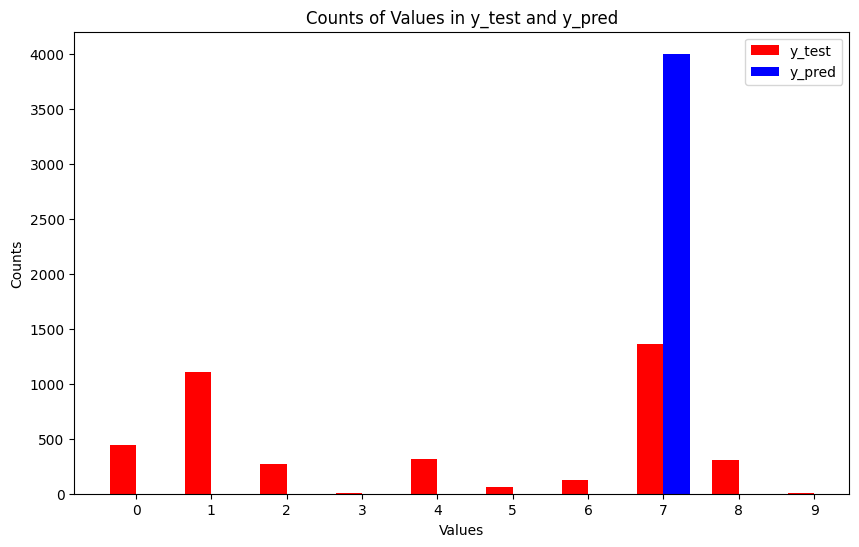

In [52]:
unique_values_y_test, counts_y_test = np.unique(y_true, return_counts=True)
unique_values_y_pred, counts_y_pred = np.unique(predicted_labels_new, return_counts=True)

# Create a bar plot
width = 0.35  # Width of the bars
fig, ax = plt.subplots(figsize=(10, 6))
bar1 = ax.bar(unique_values_y_test - width/2, counts_y_test, width, label='y_test', color='red')
bar2 = ax.bar(unique_values_y_pred + width/2, counts_y_pred, width, label='y_pred', color='blue')

# Add labels, title, and legend
ax.set_xlabel('Values')
ax.set_ylabel('Counts')
ax.set_title('Counts of Values in y_test and y_pred')
ax.set_xticks(np.unique(np.concatenate([y_true, predicted_labels_new])))
ax.legend()

# Show the plot
plt.show()